# BirdCLEF 2024 [Inference]

## Features
- PyTorch's Dataset & Dataloader
- Use PyTorch-Lightning for building model
- Data slice is based on @MARK WIJKHUIZEN's [notebook](https://www.kaggle.com/code/markwijkhuizen/birdclef-2024-efficientvit-inference).

# Import Packages

In [1]:
%%capture
# !pip install torch==1.12.0 torchvision==0.13.0 torchaudio==0.12.0
# !pip install pytorch_lightning==2.1
# !pip install pandas librosa opencv-python matplotlib  #cupy-cuda110 
# !pip install -U albumentations

In [2]:
import re
import os
import gc
import sys
import cv2
import math
import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import librosa
from scipy import signal as sci_signal
from tqdm import tqdm
import torch
from torch import nn
from torchvision.models import efficientnet

import albumentations as albu

import pytorch_lightning as pl
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configuration

In [3]:
class CONFIG:
    
    # == GENERAL ==
    seed = 42                           # random seed
    device = 'cpu'                         # device to be used
    
    # == DATA ==
    preprocessed_data = '../../preprocessed_data/imgs_v0/'                  # Path for processed data to be stores (Must put on .gitignore to not send to repo)
    checkpoint_dir = '../chpks/effnet_mixup_backgroundnoise'  # Checkpoints path (Must put on .gitignore to not send to repo)
    data_dir_2024 = '../../data/2024'# root folder
    sr = 32000                              # sampling rate
    n_fft = 1095                            # NFFT of Spec.
    win_len = 412                           # WIN_SIZE of Spec.
    hop_len = 100                           # overlap of Spec.
    min_freq = 100                           # min frequency
    max_freq = 16000                        # max frequency
    
    # == MODEL ==
    model = 'efficientnet_b0'               # model architecture
    
    # == DATASET ==
    batch_size = 64                         # batch size of each step
    n_workers = 4                           # number of workers

print('fix seed')
pl.seed_everything(CONFIG.seed, workers=True)

Seed set to 42


fix seed


42

In [4]:
# labels
label_list = sorted(os.listdir(os.path.join(CONFIG.data_dir_2024, 'train_audio')))
label_id_list = list(range(len(label_list)))
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))

# Dataset & Dataloader

## Pre-Processing

In [5]:
def oog2spec_via_scipy(audio_data):
    # handles NaNs
    mean_signal = np.nanmean(audio_data)
    audio_data = np.nan_to_num(audio_data, nan=mean_signal) if np.isnan(audio_data).mean() < 1 else np.zeros_like(audio_data)
    
    # to spec.
    frequencies, times, spec_data = sci_signal.spectrogram(
        audio_data, 
        fs=CONFIG.sr, 
        nfft=CONFIG.n_fft, 
        nperseg=CONFIG.win_len, 
        noverlap=CONFIG.hop_len, 
        window='hann'
    )
    
    # Filter frequency range
    valid_freq = (frequencies >= CONFIG.min_freq) & (frequencies <= CONFIG.max_freq)
    spec_data = spec_data[valid_freq, :]
    
    # Log
    spec_data = np.log10(spec_data + 1e-20)
    
    # min/max normalize
    spec_data = spec_data - spec_data.min()
    spec_data = spec_data / spec_data.max()
    
    return spec_data

In [6]:
all_bird_data = dict()

# https://www.kaggle.com/code/markwijkhuizen/birdclef-2024-efficientvit-inference
if len(glob(f'{CONFIG.data_dir_2024}/test_soundscapes/*.ogg')) > 0:
    ogg_file_paths = glob(f'{CONFIG.data_dir_2024}/test_soundscapes/*.ogg')
else:
    ogg_file_paths = sorted(glob(f'{CONFIG.data_dir_2024}/unlabeled_soundscapes/*.ogg'))[:10]

for i, file_path in tqdm(enumerate(ogg_file_paths)):

    row_id = re.search(r'/([^/]+)\.ogg$', file_path).group(1)  # filename

    audio_data, _ = librosa.load(file_path, sr=CONFIG.sr)
    
    # to spec.
    spec = oog2spec_via_scipy(audio_data)
    
    # pad
    pad = 512 - (spec.shape[1] % 512)
    if pad > 0:
        spec = np.pad(spec, ((0,0), (0,pad)))
    
    # reshape
    spec = spec.reshape(544,-1,512).transpose([0, 2, 1])
    spec = cv2.resize(spec, (256, 256), interpolation=cv2.INTER_LINEAR)
    
    for j in range(48):
        all_bird_data[f'{row_id}_{(j+1)*5}'] = spec[:, :, j]

10it [00:11,  1.12s/it]


In [7]:
_

32000

## Dataset

In [8]:
class BirdDataset(torch.utils.data.Dataset):
    
    def __init__(
        self,
        bird_data,
        augmentation=None,
    ):
        super().__init__()
        self.bird_data = bird_data
        self.keys_list = list(bird_data.keys())
        self.augmentation = augmentation
    
    def __len__(self):
        return len(self.bird_data)
    
    def __getitem__(self, index):
        
        _spec = self.bird_data[self.keys_list[index]]
        
        if self.augmentation is not None:
            _spec = self.augmentation(image=_spec)['image'] 
        
        return torch.tensor(_spec, dtype=torch.float32)

## Augmentation

In [9]:
def get_transforms(_type):
    
    if _type == 'test':
        return albu.Compose([])

## Visualize

In [10]:
def show_batch(ds, row=2, col=2):
    fig = plt.figure(figsize=(6, 6))
    img_index = np.random.randint(0, len(ds)-1, row*col)
    
    for i in range(len(img_index)):
        img = dummy_dataset[img_index[i]]
        
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        
        ax = fig.add_subplot(2, 2, i + 1, xticks=[], yticks=[])
        ax.imshow(img, cmap='jet')
        ax.set_title(f'ID: {img_index[i]}')
    
    plt.tight_layout()
    plt.show()

(256, 256)


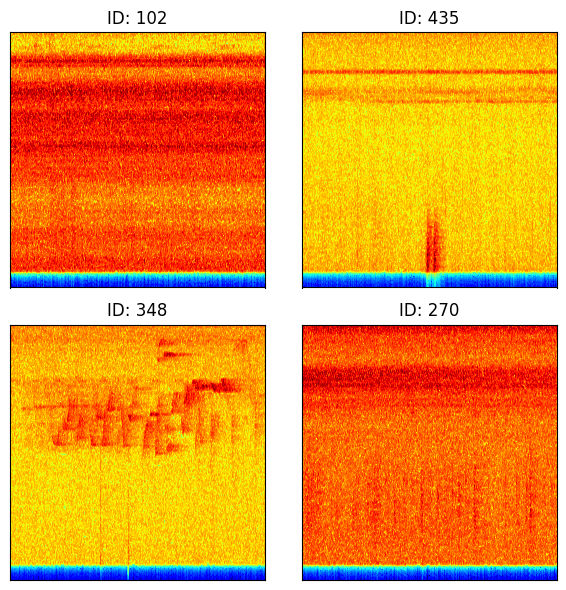

11003

In [11]:
dummy_dataset = BirdDataset(all_bird_data, get_transforms('test'))

test_input = dummy_dataset[0]
print(test_input.detach().numpy().shape)

show_batch(dummy_dataset)

del dummy_dataset
gc.collect()

## Network

In [12]:
class EffNet(nn.Module):
    
    def __init__(self, model_type, n_classes, pretrained=False):
        super().__init__()
        
        if model_type == 'efficientnet_b0':
            if pretrained: weights = efficientnet.EfficientNet_B0_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b0(weights=weights)
        elif model_type == 'efficientnet_b1':
            if pretrained: weights = efficientnet.EfficientNet_B1_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b1(weights=weights)
        elif model_type == 'efficientnet_b2':
            if pretrained: weights = efficientnet.EfficientNet_B2_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b2(weights=weights)
        elif model_type == 'efficientnet_b3':
            if pretrained: weights = efficientnet.EfficientNet_B3_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b3(weights=weights)
        else:
            raise ValueError('model type not supported')
        
        self.base_model.classifier[1] = nn.Linear(self.base_model.classifier[1].in_features, n_classes, dtype=torch.float32)
    
    def forward(self, x):
        x = x.unsqueeze(-1)
        x = torch.cat([x, x, x], dim=3).permute(0, 3, 1, 2)
        return self.base_model(x)

## Lightning Module

In [13]:
class BirdModel(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        # == backbone ==
        self.backbone = EffNet(CONFIG.model, n_classes=len(label_list))
        
        # == loss function ==
        self.loss_fn = nn.CrossEntropyLoss()
        
        # == record ==
        self.validation_step_outputs = []
        
    def forward(self, images):
        return self.backbone(images)
    
    def configure_optimizers(self):
        
        # == define optimizer ==
        model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.parameters()),
            lr=CONFIG.lr,
            weight_decay=CONFIG.weight_decay
        )
        
        # == define learning rate scheduler ==
        lr_scheduler = CosineAnnealingWarmRestarts(
            model_optimizer,
            T_0=CONFIG.epochs,
            T_mult=1,
            eta_min=1e-6,
            last_epoch=-1
        )
        
        return {
            'optimizer': model_optimizer,
            'lr_scheduler': {
                'scheduler': lr_scheduler,
                'interval': 'epoch',
                'monitor': 'val_loss',
                'frequency': 1
            }
        }
    
    def training_step(self, batch, batch_idx):
        
        # == obtain input and target ==
        image, target = batch
        image = image.to(self.device)
        target = target.to(self.device)
        
        # == pred ==
        y_pred = self(image)
        
        # == compute loss ==
        train_loss = self.loss_fn(y_pred, target)
        
        # == record ==
        self.log('train_loss', train_loss, True)
        
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        
        # == obtain input and target ==
        image, target = batch
        image = image.to(self.device)
        target = target.to(self.device)
        
        # == pred ==
        with torch.no_grad():
            y_pred = self(image)
            
        self.validation_step_outputs.append({"logits": y_pred, "targets": target})
        
    def train_dataloader(self):
        return self._train_dataloader

    def validation_dataloader(self):
        return self._validation_dataloader
    
    def on_validation_epoch_end(self):
        
        # = merge batch data =
        outputs = self.validation_step_outputs
        
        output_val = nn.Softmax(dim=1)(torch.cat([x['logits'] for x in outputs], dim=0)).cpu().detach()
        target_val = torch.cat([x['targets'] for x in outputs], dim=0).cpu().detach()
        
        # = compute validation loss =
        val_loss = self.loss_fn(output_val, target_val)
        
        # target to one-hot
        target_val = torch.nn.functional.one_hot(target_val, len(label_list))
        
        # = val with ROC AUC =
        gt_df = pd.DataFrame(target_val.numpy().astype(np.float32), columns=label_list)
        pred_df = pd.DataFrame(output_val.numpy().astype(np.float32), columns=label_list)
        
        gt_df['id'] = [f'id_{i}' for i in range(len(gt_df))]
        pred_df['id'] = [f'id_{i}' for i in range(len(pred_df))]
        
        val_score = score(gt_df, pred_df, row_id_column_name='id')
        
        self.log("val_score", val_score, True)
        
        return {'val_loss': val_loss, 'val_score': val_score}

# Functions of Inference Loop

In [14]:
def predict(data_loader, model):
    model.to(CONFIG.device)
    model.eval()
    pred = []
    for batch in tqdm(data_loader):
        with torch.no_grad():
            x = batch
            outputs = model(x)
            outputs = nn.Softmax(dim=1)(outputs)
        pred.append(outputs.detach().cpu())
    
    pred = torch.cat(pred, dim=0).cpu().detach()
    
    return pred.numpy().astype(np.float32)

# Inference & Submision

## ckpts

In [20]:
ckpt_list = glob(f'{CONFIG.checkpoint_dir}/*.ckpt')
print(f'find {len(ckpt_list)} ckpts in {CONFIG.checkpoint_dir}.')
# ckpt_list = [ckpt_list[-1]]
ckpt_list

find 3 ckpts in ../chpks/effnet_mixup_backgroundnoise.


['../chpks/effnet_mixup_backgroundnoise/fold_2.ckpt',
 '../chpks/effnet_mixup_backgroundnoise/fold_1.ckpt',
 '../chpks/effnet_mixup_backgroundnoise/fold_0.ckpt']

In [ ]:
# effnet_5fold_kfold

In [18]:
ckpt_list = glob(f'../chpks/effnet_5fold_kfold/*.ckpt')
print(f'find {len(ckpt_list)} ckpts in {CONFIG.checkpoint_dir}.')
# ckpt_list = [ckpt_list[-1]]
ckpt_list

find 5 ckpts in ../chpks/effnet_mixup_backgroundnoise.


['../chpks/effnet_5fold_kfold/fold_2.ckpt',
 '../chpks/effnet_5fold_kfold/fold_3.ckpt',
 '../chpks/effnet_5fold_kfold/fold_4.ckpt',
 '../chpks/effnet_5fold_kfold/fold_1.ckpt',
 '../chpks/effnet_5fold_kfold/fold_0.ckpt']

In [17]:
torch.__version__

'1.12.0+cu102'

## Main Loop

In [21]:
predictions = []

for ckpt in ckpt_list:
    
    # == init model ==
    bird_model = BirdModel()
    
    # == load ckpt ==
    weights = torch.load(ckpt, map_location=torch.device('cpu'))['state_dict']
    bird_model.load_state_dict(weights)
    
    # == create dataset & dataloader ==
    test_dataset = BirdDataset(all_bird_data, get_transforms('test'))
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=CONFIG.batch_size,
        num_workers=CONFIG.n_workers,
        shuffle=False,
        drop_last=False
    )
    
    predictions.append(predict(test_loader, bird_model))
    gc.collect()

predictions = np.mean(predictions, axis=0)

 50%|██████████████████████████████████████████▌                                          | 4/8 [00:04<00:04,  1.17s/it]


KeyboardInterrupt: 

In [18]:
sub_pred = pd.DataFrame(predictions, columns=label_list)
sub_id = pd.DataFrame({'row_id': list(all_bird_data.keys())})

sub = pd.concat([sub_id, sub_pred], axis=1)

sub.to_csv('submission.csv',index=False)
print(f'Submissionn shape: {sub.shape}')
sub.head(5)

Submissionn shape: (480, 183)


,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1
0,1000170626_5,0.002536,0.006430,0.001549,0.002417,0.000939,0.001357,0.004691,0.001294,0.005007,...,0.001496,0.004970,0.008336,0.010913,0.004185,0.015014,0.004911,0.001017,0.003112,0.013395
1,1000170626_10,0.003347,0.003611,0.002308,0.002415,0.001358,0.002371,0.005060,0.001449,0.008468,...,0.002819,0.005907,0.006530,0.009933,0.005022,0.006934,0.010112,0.001338,0.002405,0.010915
2,1000170626_15,0.002797,0.003023,0.002910,0.002528,0.001699,0.002320,0.005165,0.001329,0.007369,...,0.003424,0.005607,0.005498,0.009963,0.003386,0.006067,0.010495,0.001476,0.002604,0.011736
3,1000170626_20,0.003035,0.004562,0.001888,0.002559,0.001456,0.002449,0.006172,0.001232,0.006534,...,0.004575,0.005829,0.005878,0.007364,0.006289,0.005991,0.011128,0.001077,0.005091,0.009614
4,1000170626_25,0.003277,0.002936,0.002336,0.002299,0.001625,0.003022,0.005342,0.001196,0.005732,...,0.005074,0.005584,0.007989,0.006920,0.004343,0.005335,0.008965,0.001384,0.003050,0.012417
